# Hyper Parameter Optimization For XGBoost

In [2]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [3]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\Scripts_git\\SingleModels\\XGBoost'

In [4]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.draw import plot_feature_importance, plot_feature_importance
from Utools.SingleModel import SingleModel

In [6]:
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

## Load Data

In [7]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [8]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")
# define the parameter grid for the XGBoost model
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 4, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
xgboost = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)  
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgboost, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

['DFT XGBoost'] HP optimazation begin...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [3, 4, 5, 7, 10],
                         'n_estimators': [200, 500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [13]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'train_rmse', 'test_rmse']]

# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'dft_grid_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Best Cross-Validation RMSE: 0.7113


,rank_test_score,param_learning_rate,param_max_depth,param_n_estimators,train_rmse,test_rmse
19,1,0.1,10,500,0.218489,0.711284
17,2,0.1,7,500,0.391442,0.711720
18,3,0.1,10,200,0.310056,0.712400
27,4,0.2,7,500,0.274704,0.714394
28,5,0.2,10,200,0.231937,0.720849


### Overfitting check

####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  15.1s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:


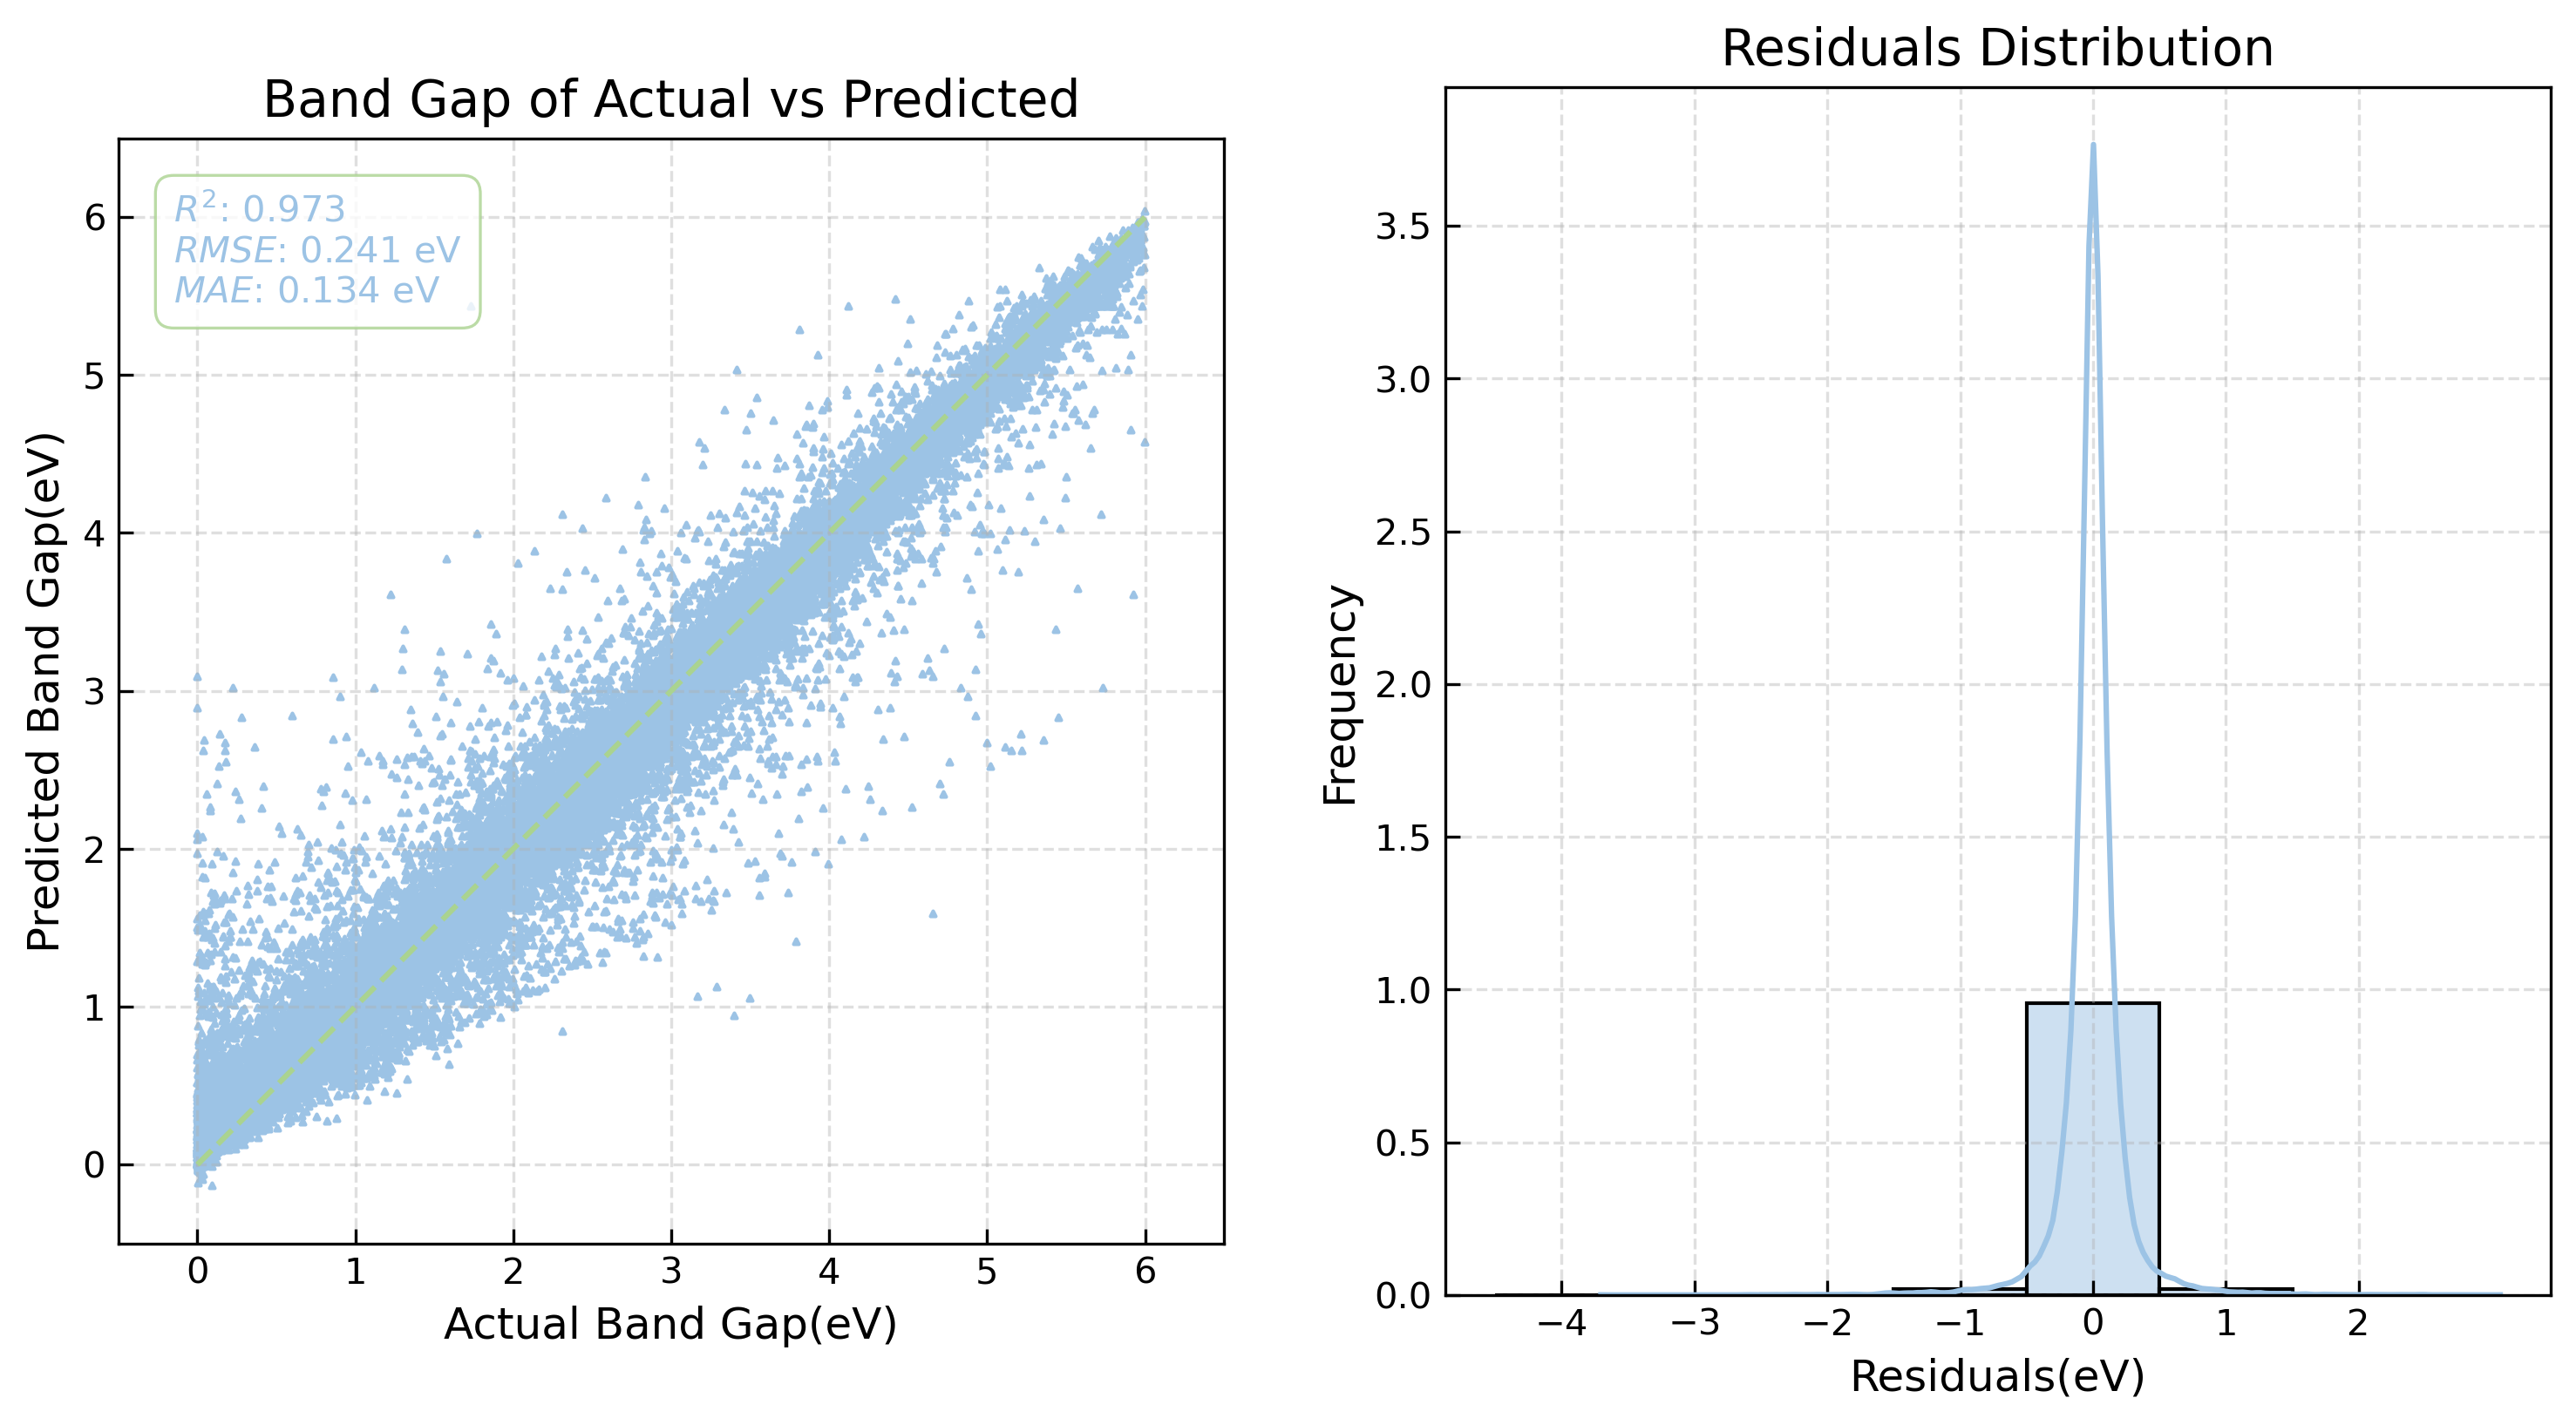


Model Evaluation Results:
Test set: R²: 0.9733 RMSE: 0.2411 MAE: 0.1340
[Test DFT -> DFT] Evaluating DFT XGBoost on DFT test set:


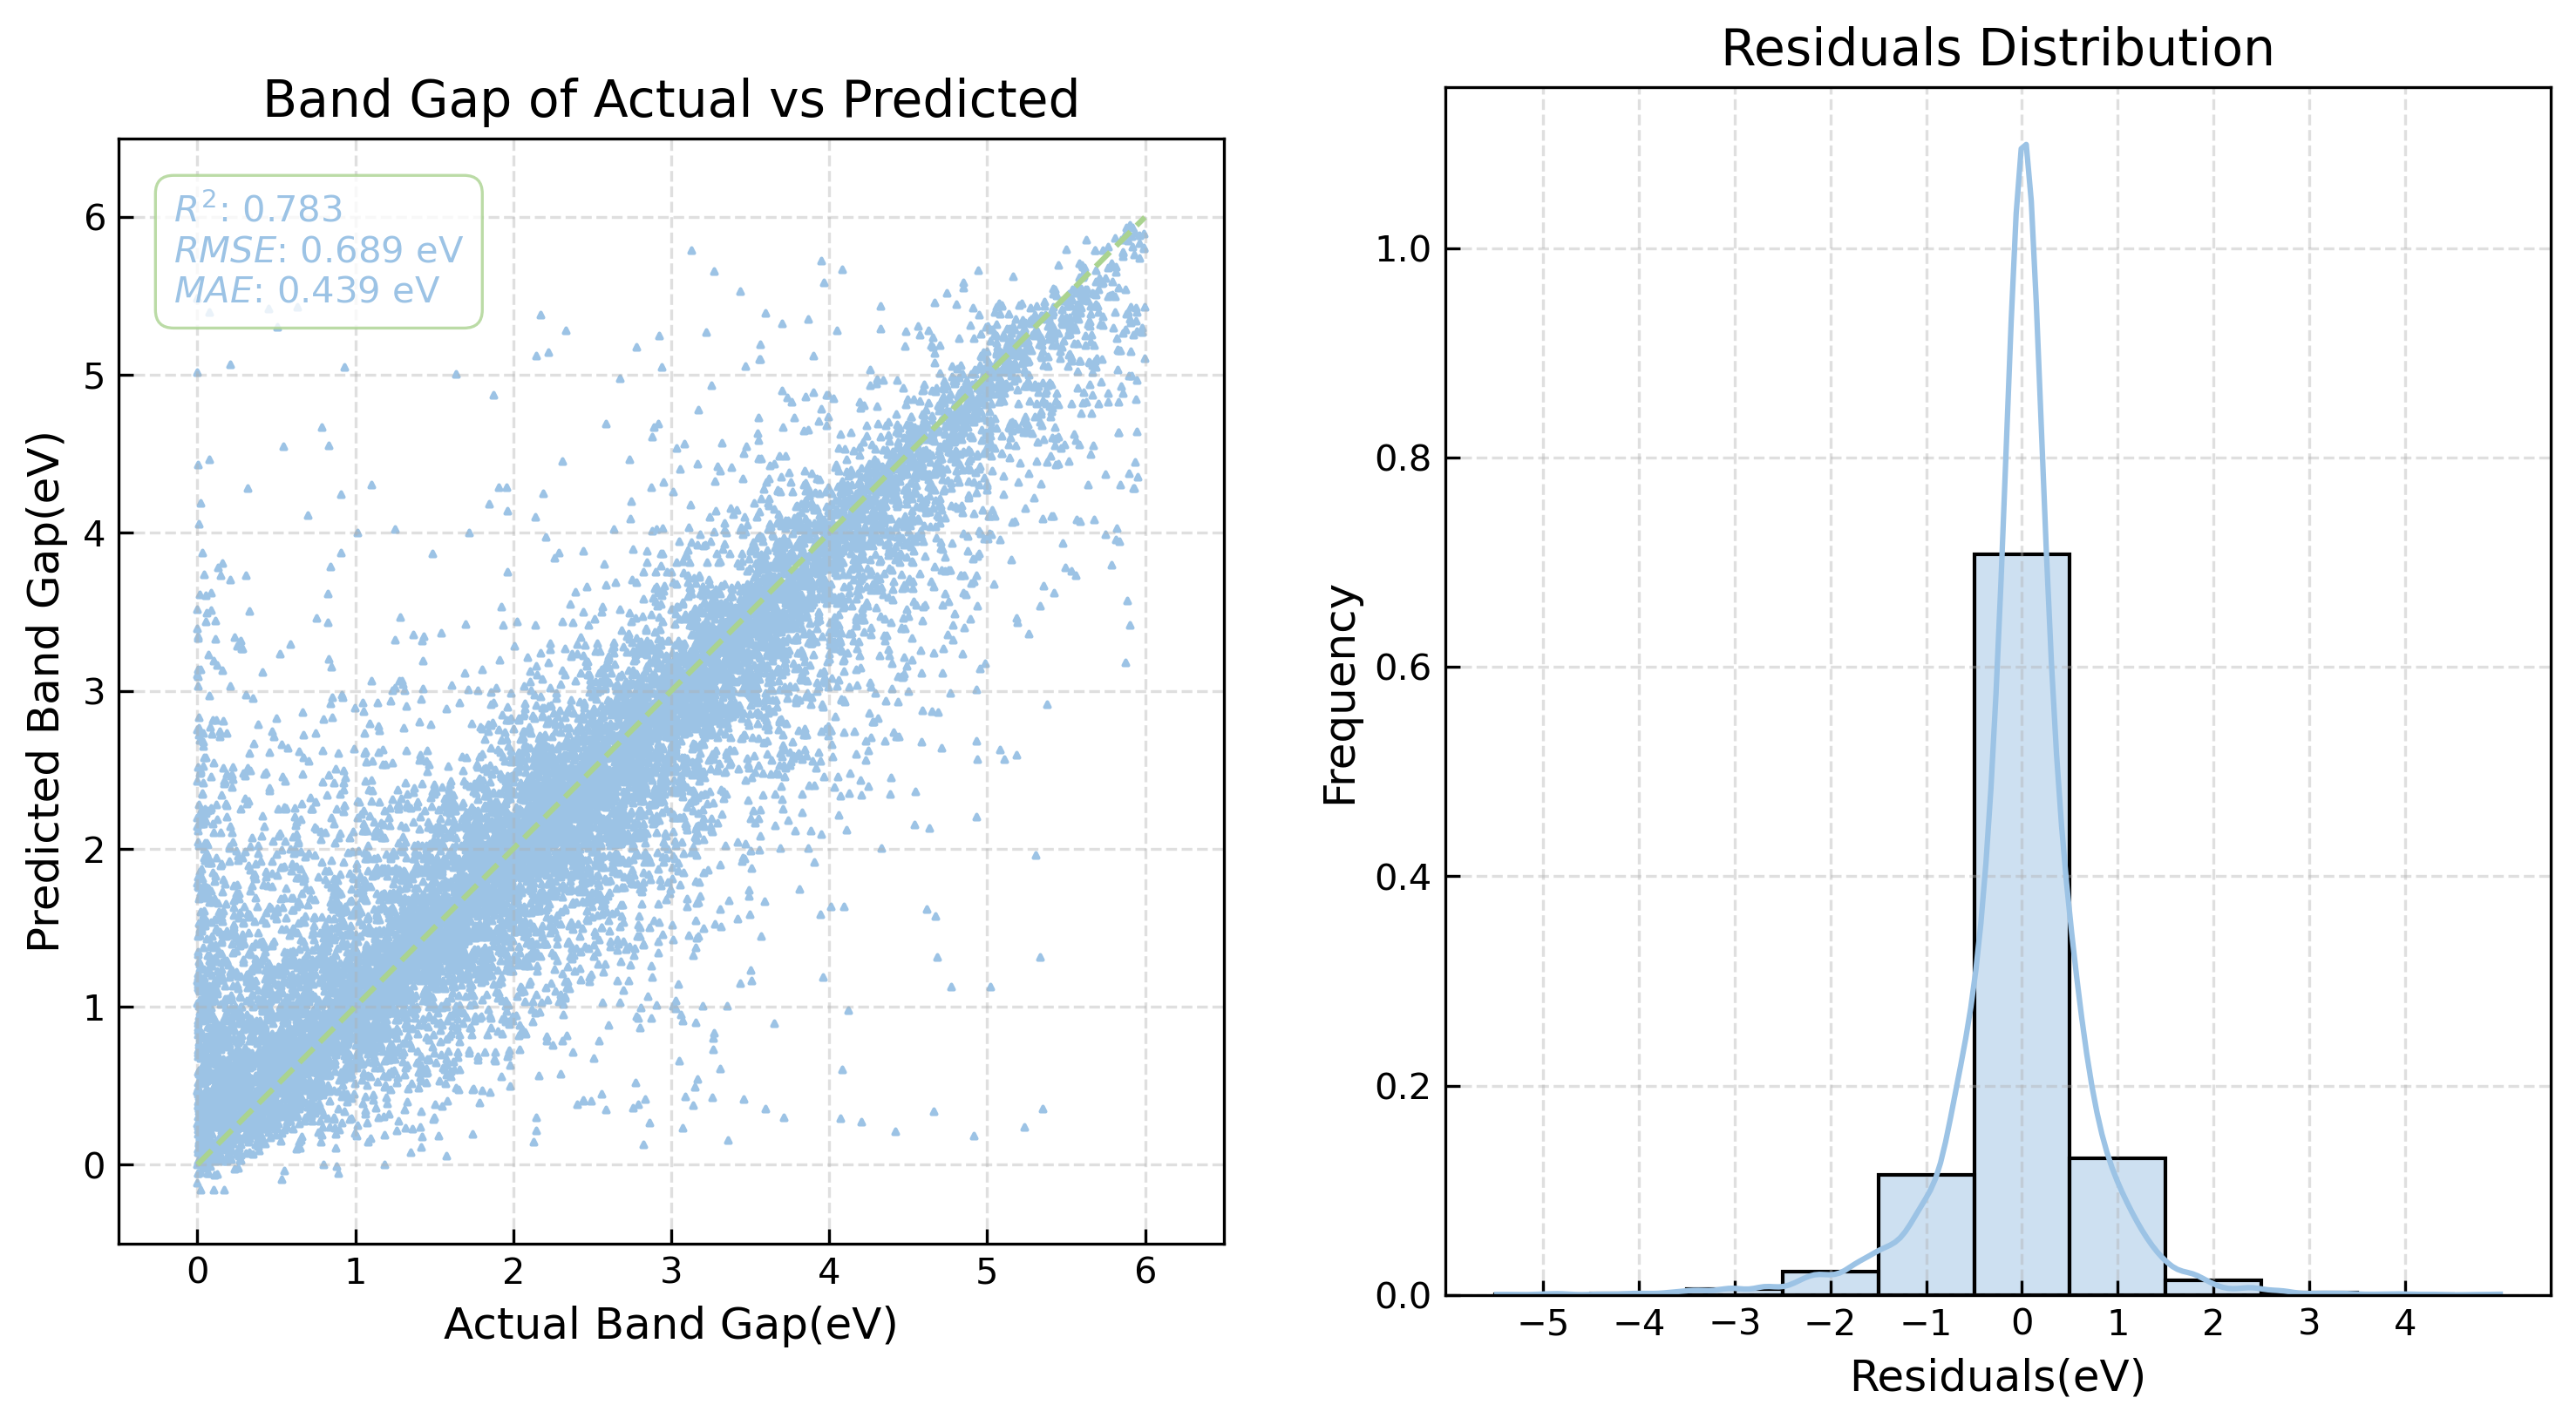


Model Evaluation Results:
Test set: R²: 0.7826 RMSE: 0.6891 MAE: 0.4388
[Test DFT -> EXP] Evaluating DFT XGBoost on EXP test set:


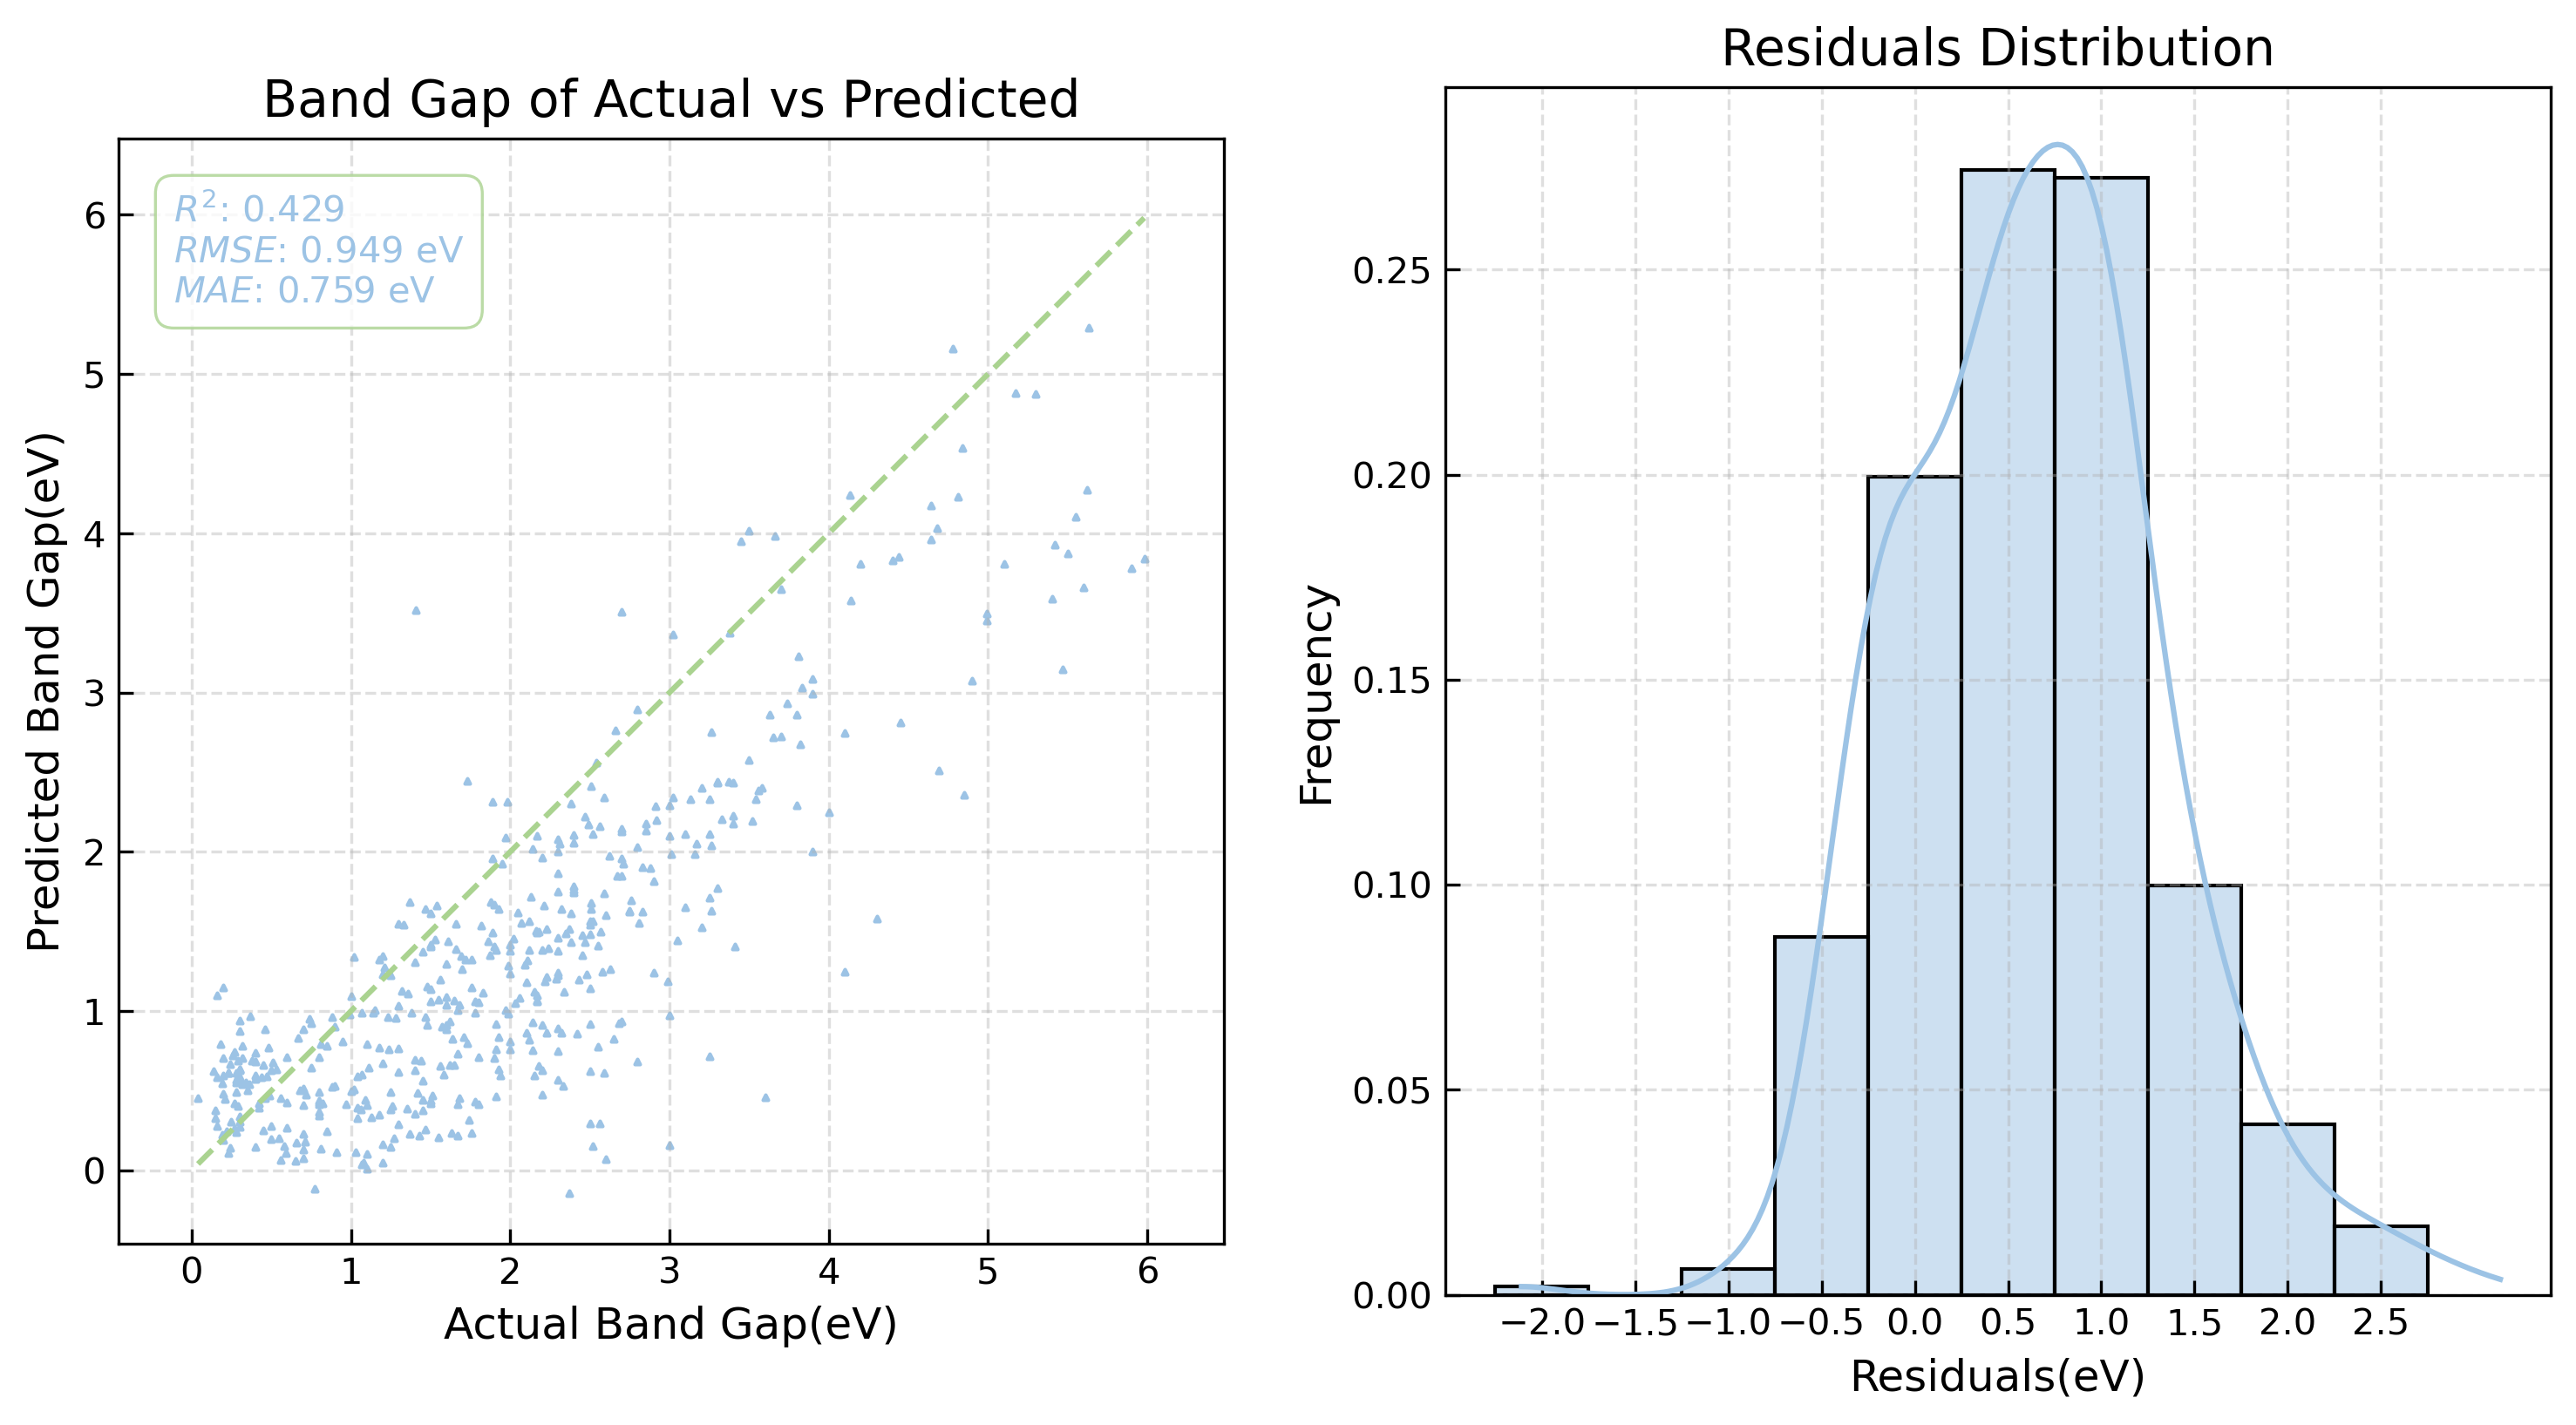


Model Evaluation Results:
Test set: R²: 0.4292 RMSE: 0.9494 MAE: 0.7586


In [44]:
# 
# Train the model with the best hyperparameters on the entire training set
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=500,
    colsample_bytree=1.0, subsample=1.0,
    objective='reg:squarederror',
    random_state=RANDOM_SEED,
    n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [45]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,dft,dft,0.973332,0.241140,0.133989
1,XGBoost,Test,dft,dft,0.782637,0.689137,0.438794
2,XGBoost,Test,dft,exp,0.429217,0.949424,0.758645


### EXP Model

In [16]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")
# define the parameter grid for the XGBoost model
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 4, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0],
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
xgboost = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)  
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgboost, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

['EXP XGBoost'] HP optimazation begin...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    impo...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [3, 4, 5, 7, 10],
                         'n_estimators': [200, 500],
                         'subsample': [0.5, 0.7, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [18]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_colsample_bytree', 'param_subsample', 'train_rmse', 'test_rmse']]

# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'exp_grid_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.7}
Best Cross-Validation RMSE: 0.5738


,rank_test_score,param_learning_rate,param_max_depth,param_n_estimators,param_colsample_bytree,param_subsample,train_rmse,test_rmse
298,1,0.10,10,500,1.0,0.7,0.012353,0.573766
268,2,0.01,10,500,1.0,0.7,0.107348,0.573822
295,3,0.10,10,200,1.0,0.7,0.013992,0.573840
291,4,0.10,7,500,1.0,0.5,0.015197,0.574000
288,5,0.10,7,200,1.0,0.5,0.062378,0.574139


### Overfitting check

####################################################################################################
[EXP - XGBoost] Training XGBoost on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.7s
Model training completed!
[Train_error] Evaluating EXP XGBoost on EXP train set:


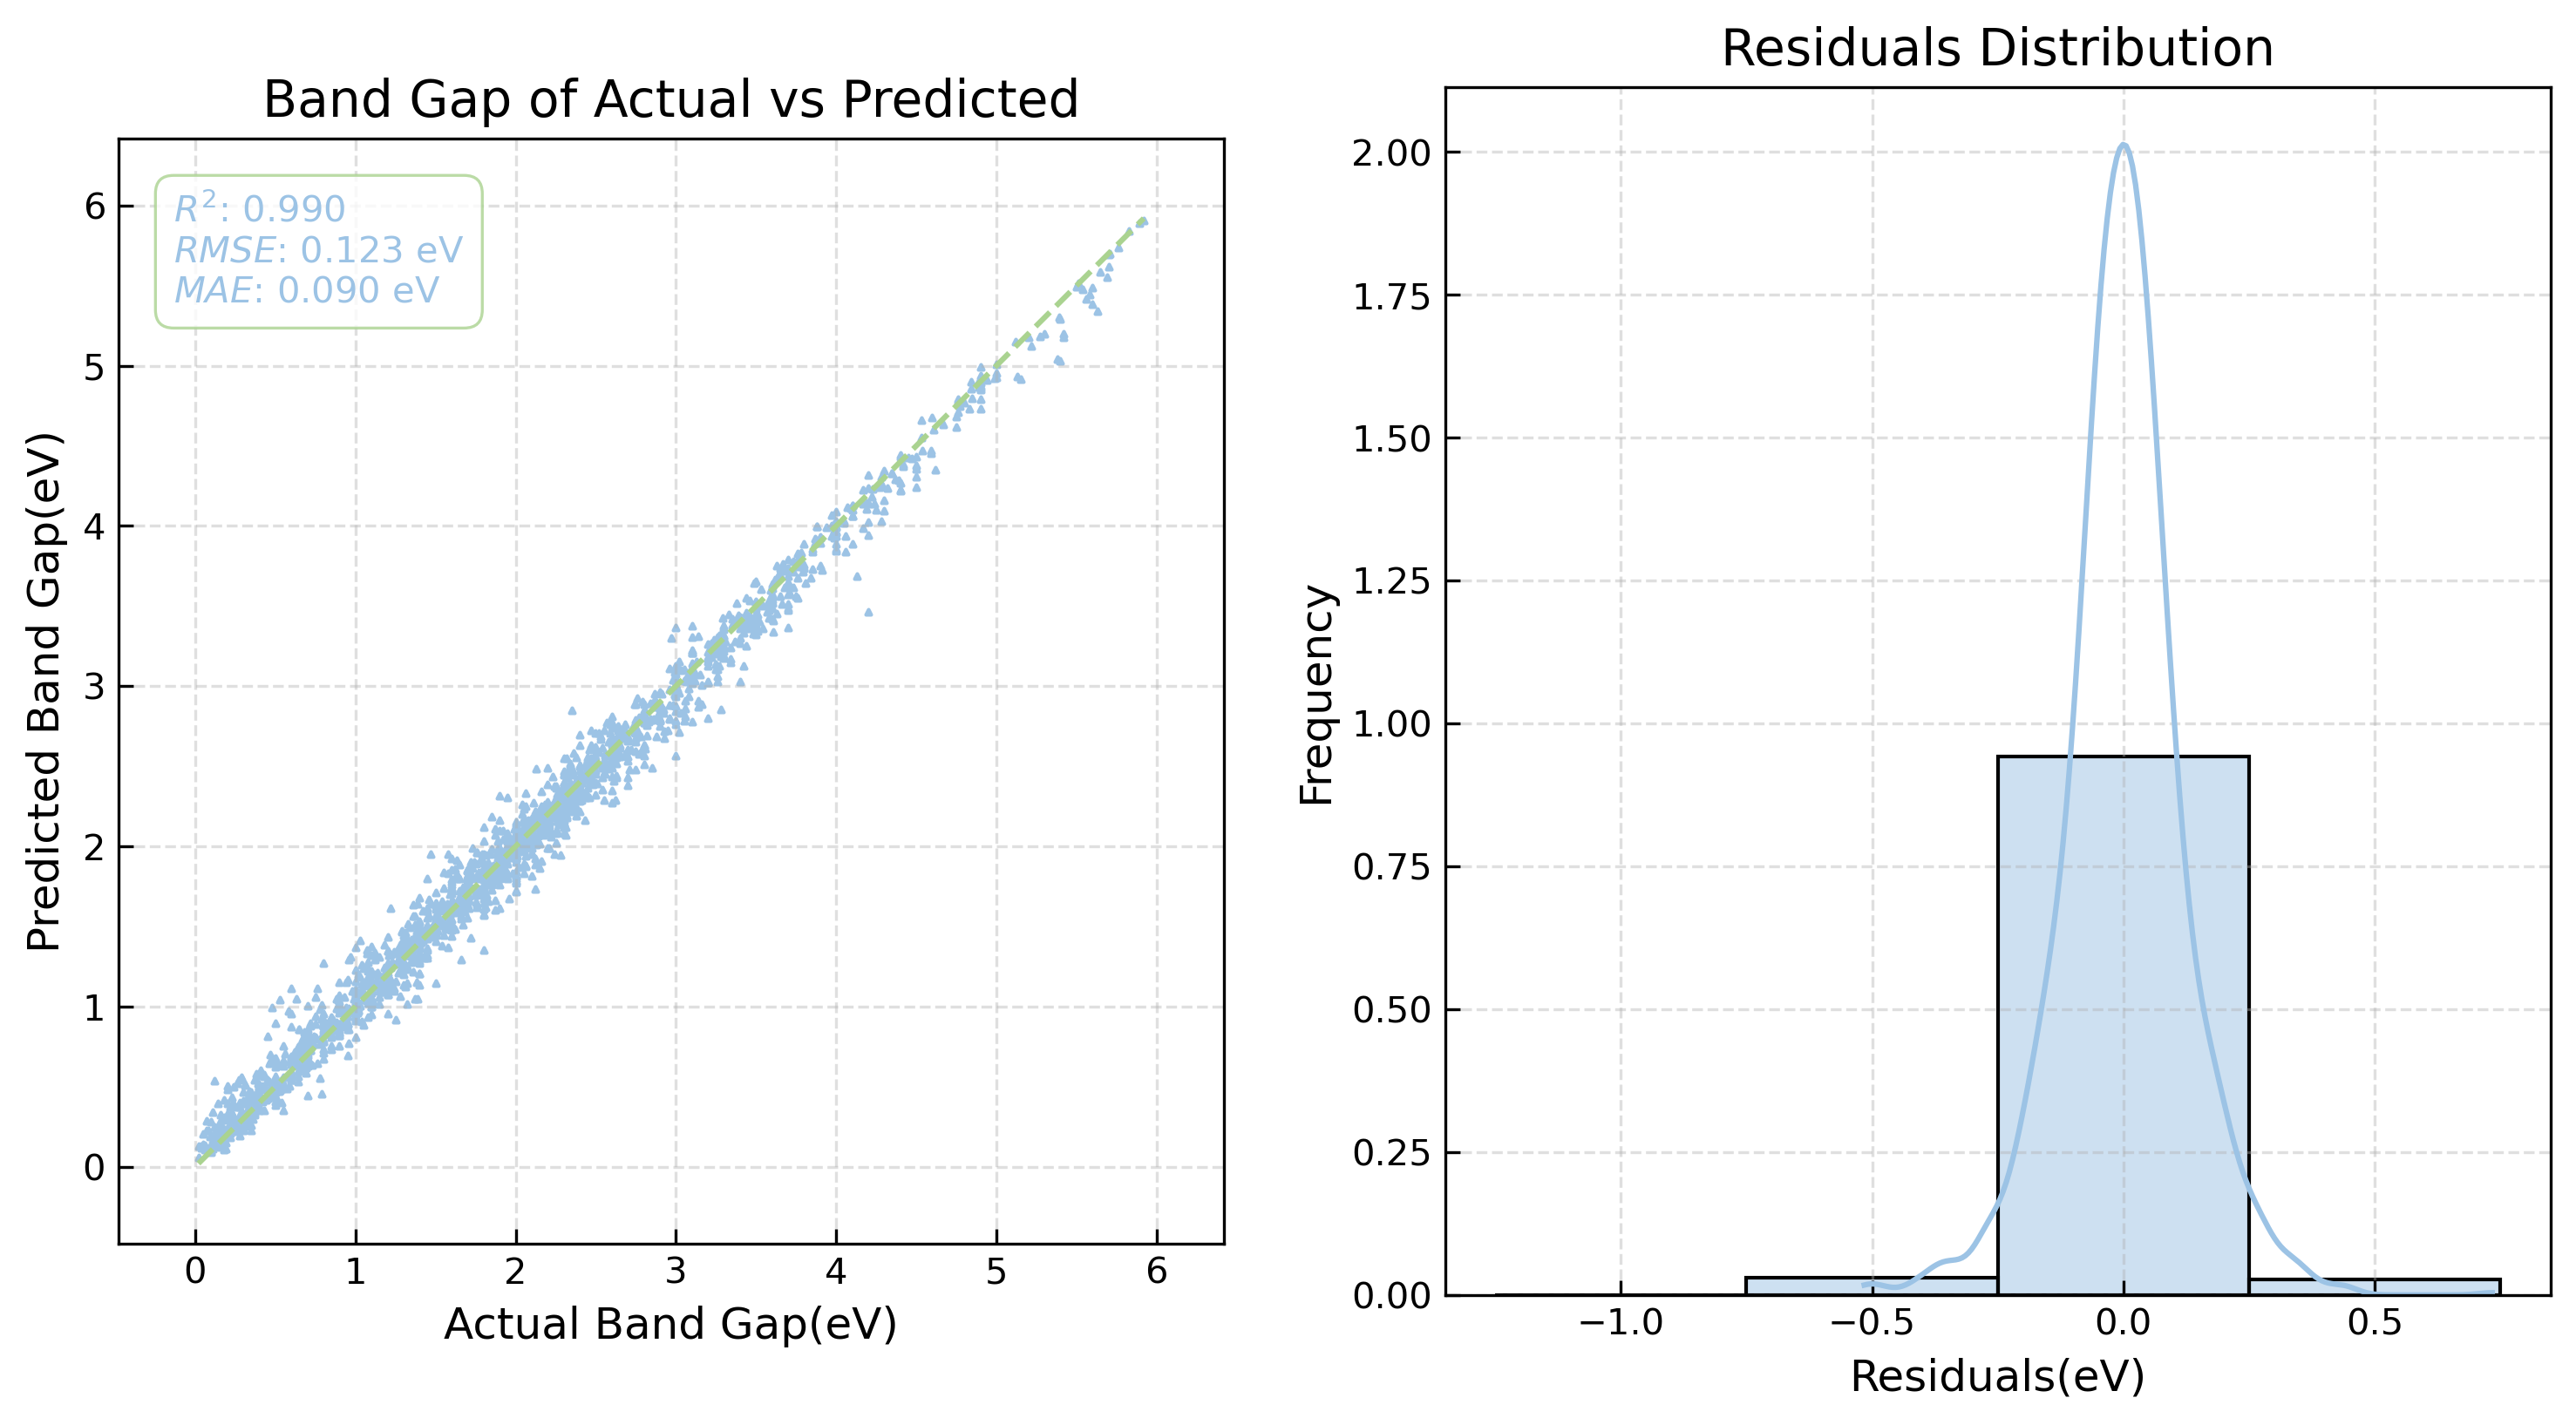


Model Evaluation Results:
Test set: R²: 0.9898 RMSE: 0.1225 MAE: 0.0896
[Test EXP -> EXP] Evaluating EXP XGBoost on EXP test set:


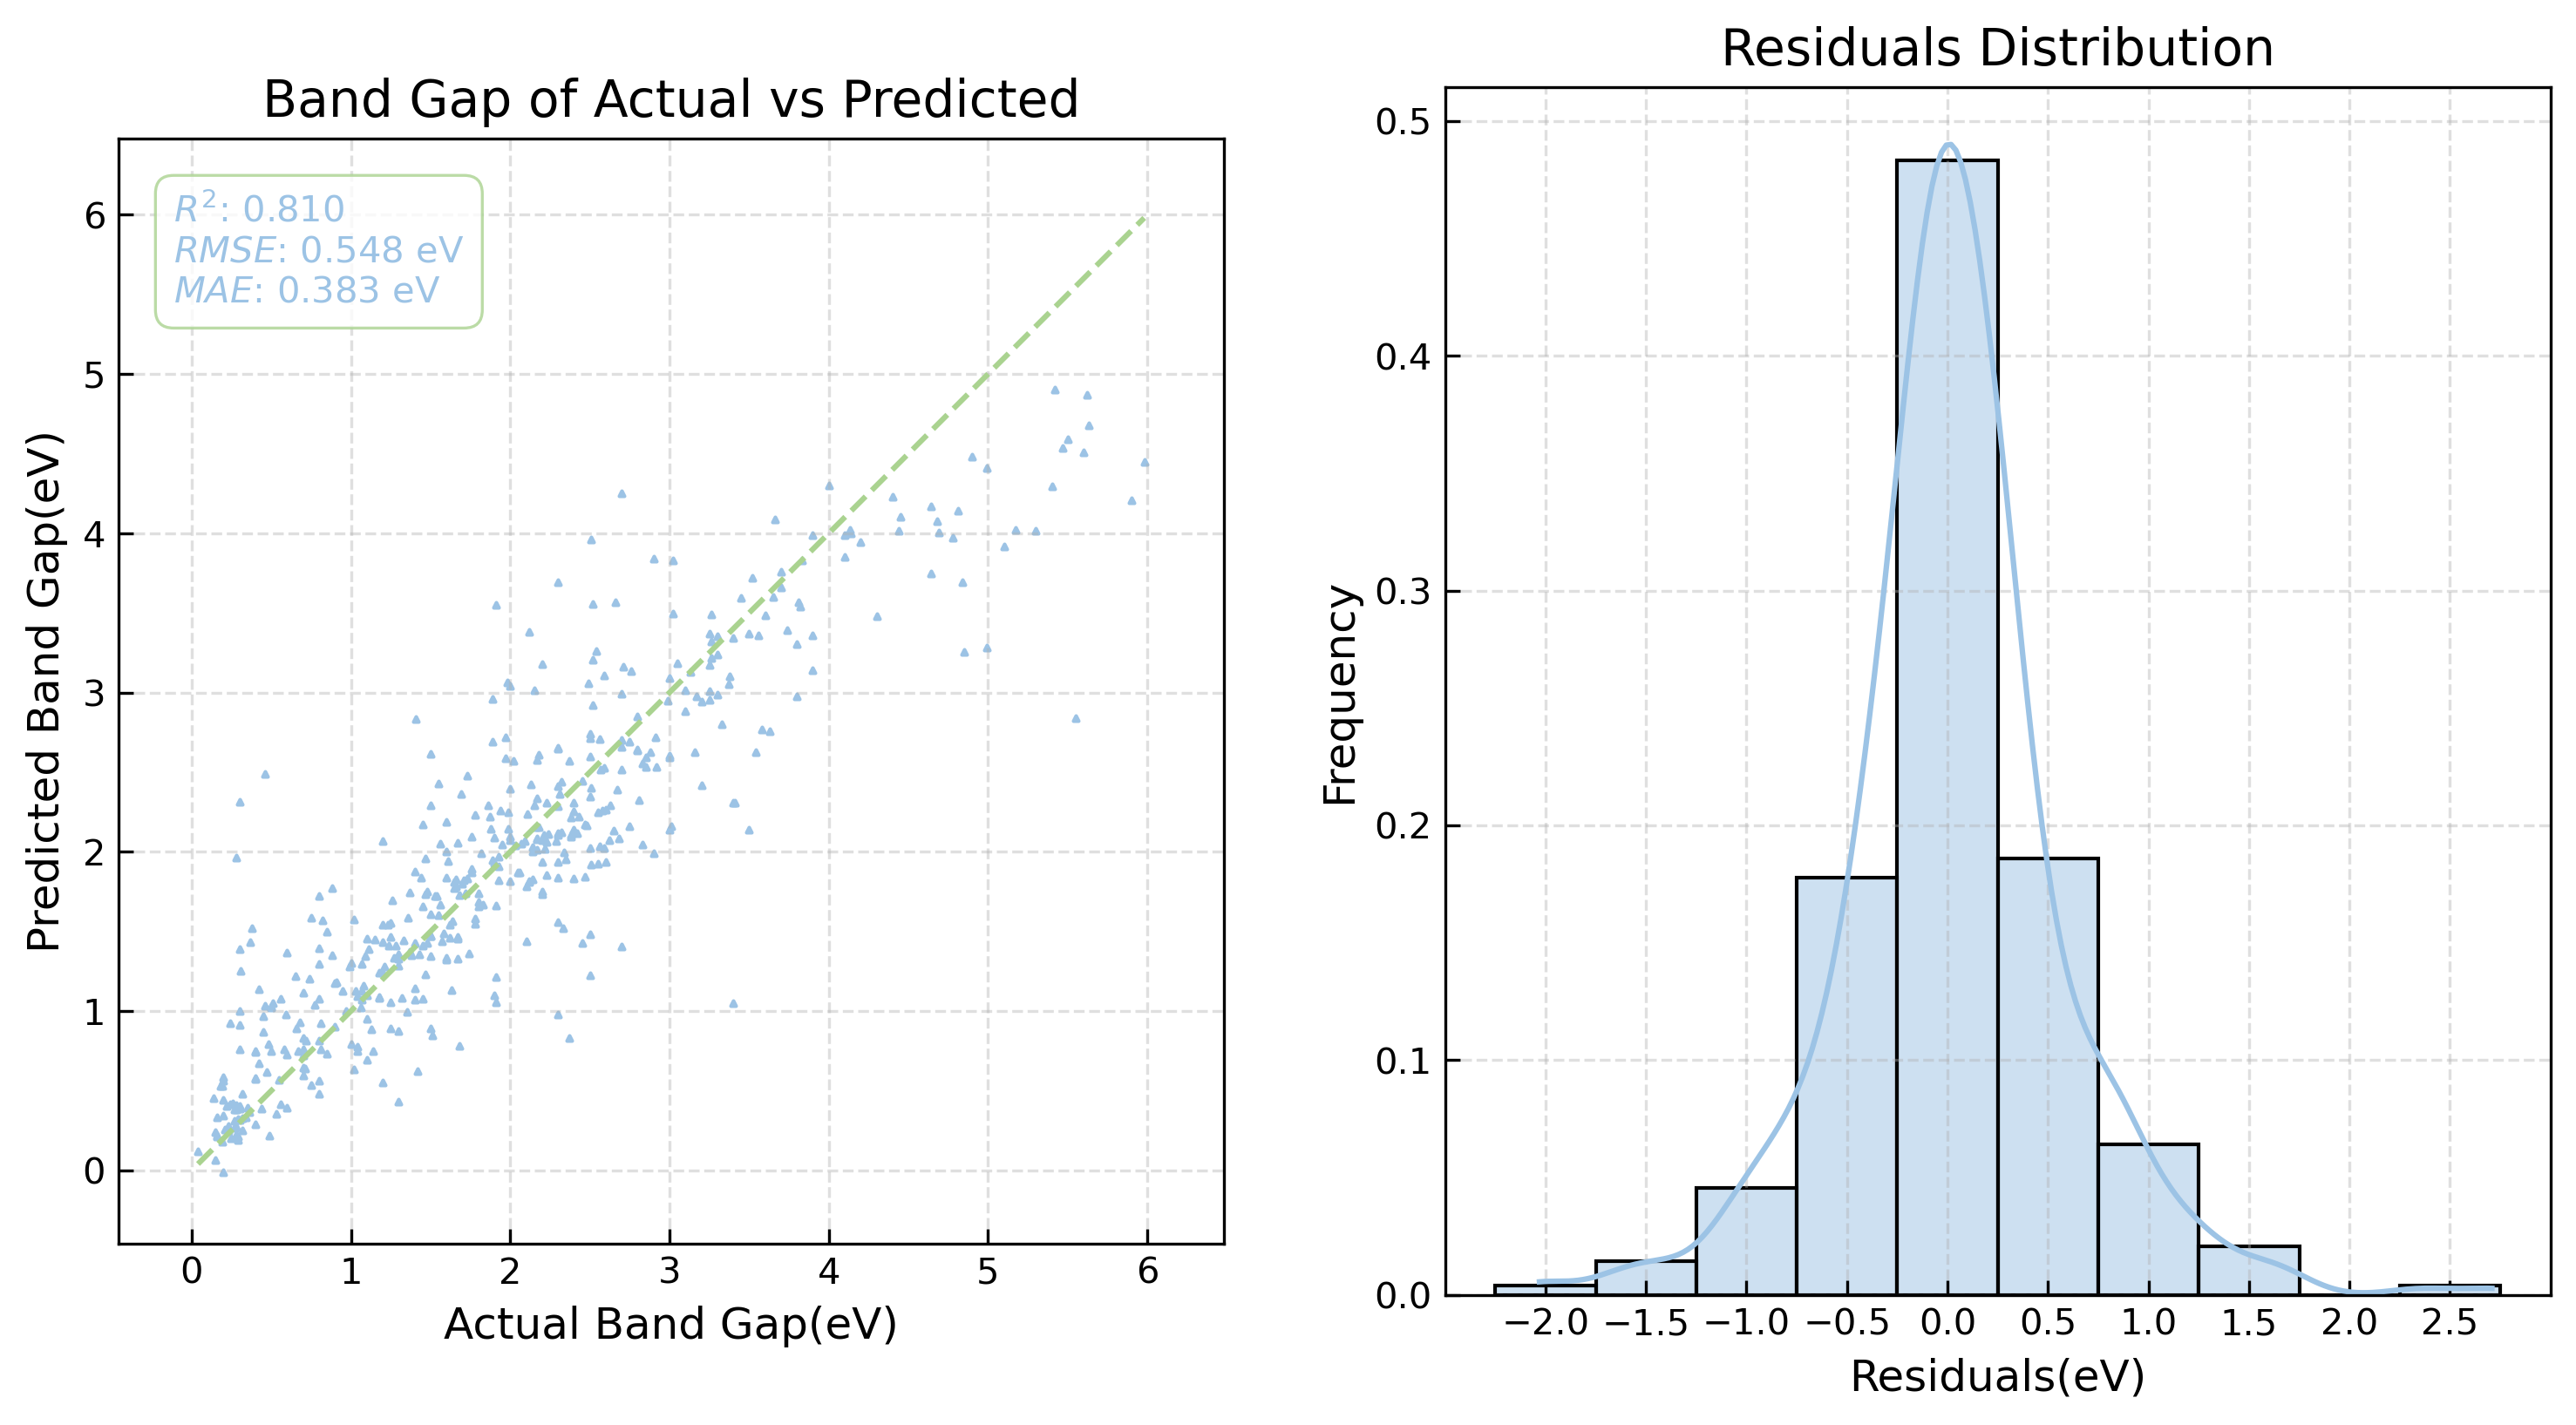


Model Evaluation Results:
Test set: R²: 0.8101 RMSE: 0.5476 MAE: 0.3830
[Test EXP -> DFT] Evaluating EXP XGBoost on DFT test set:


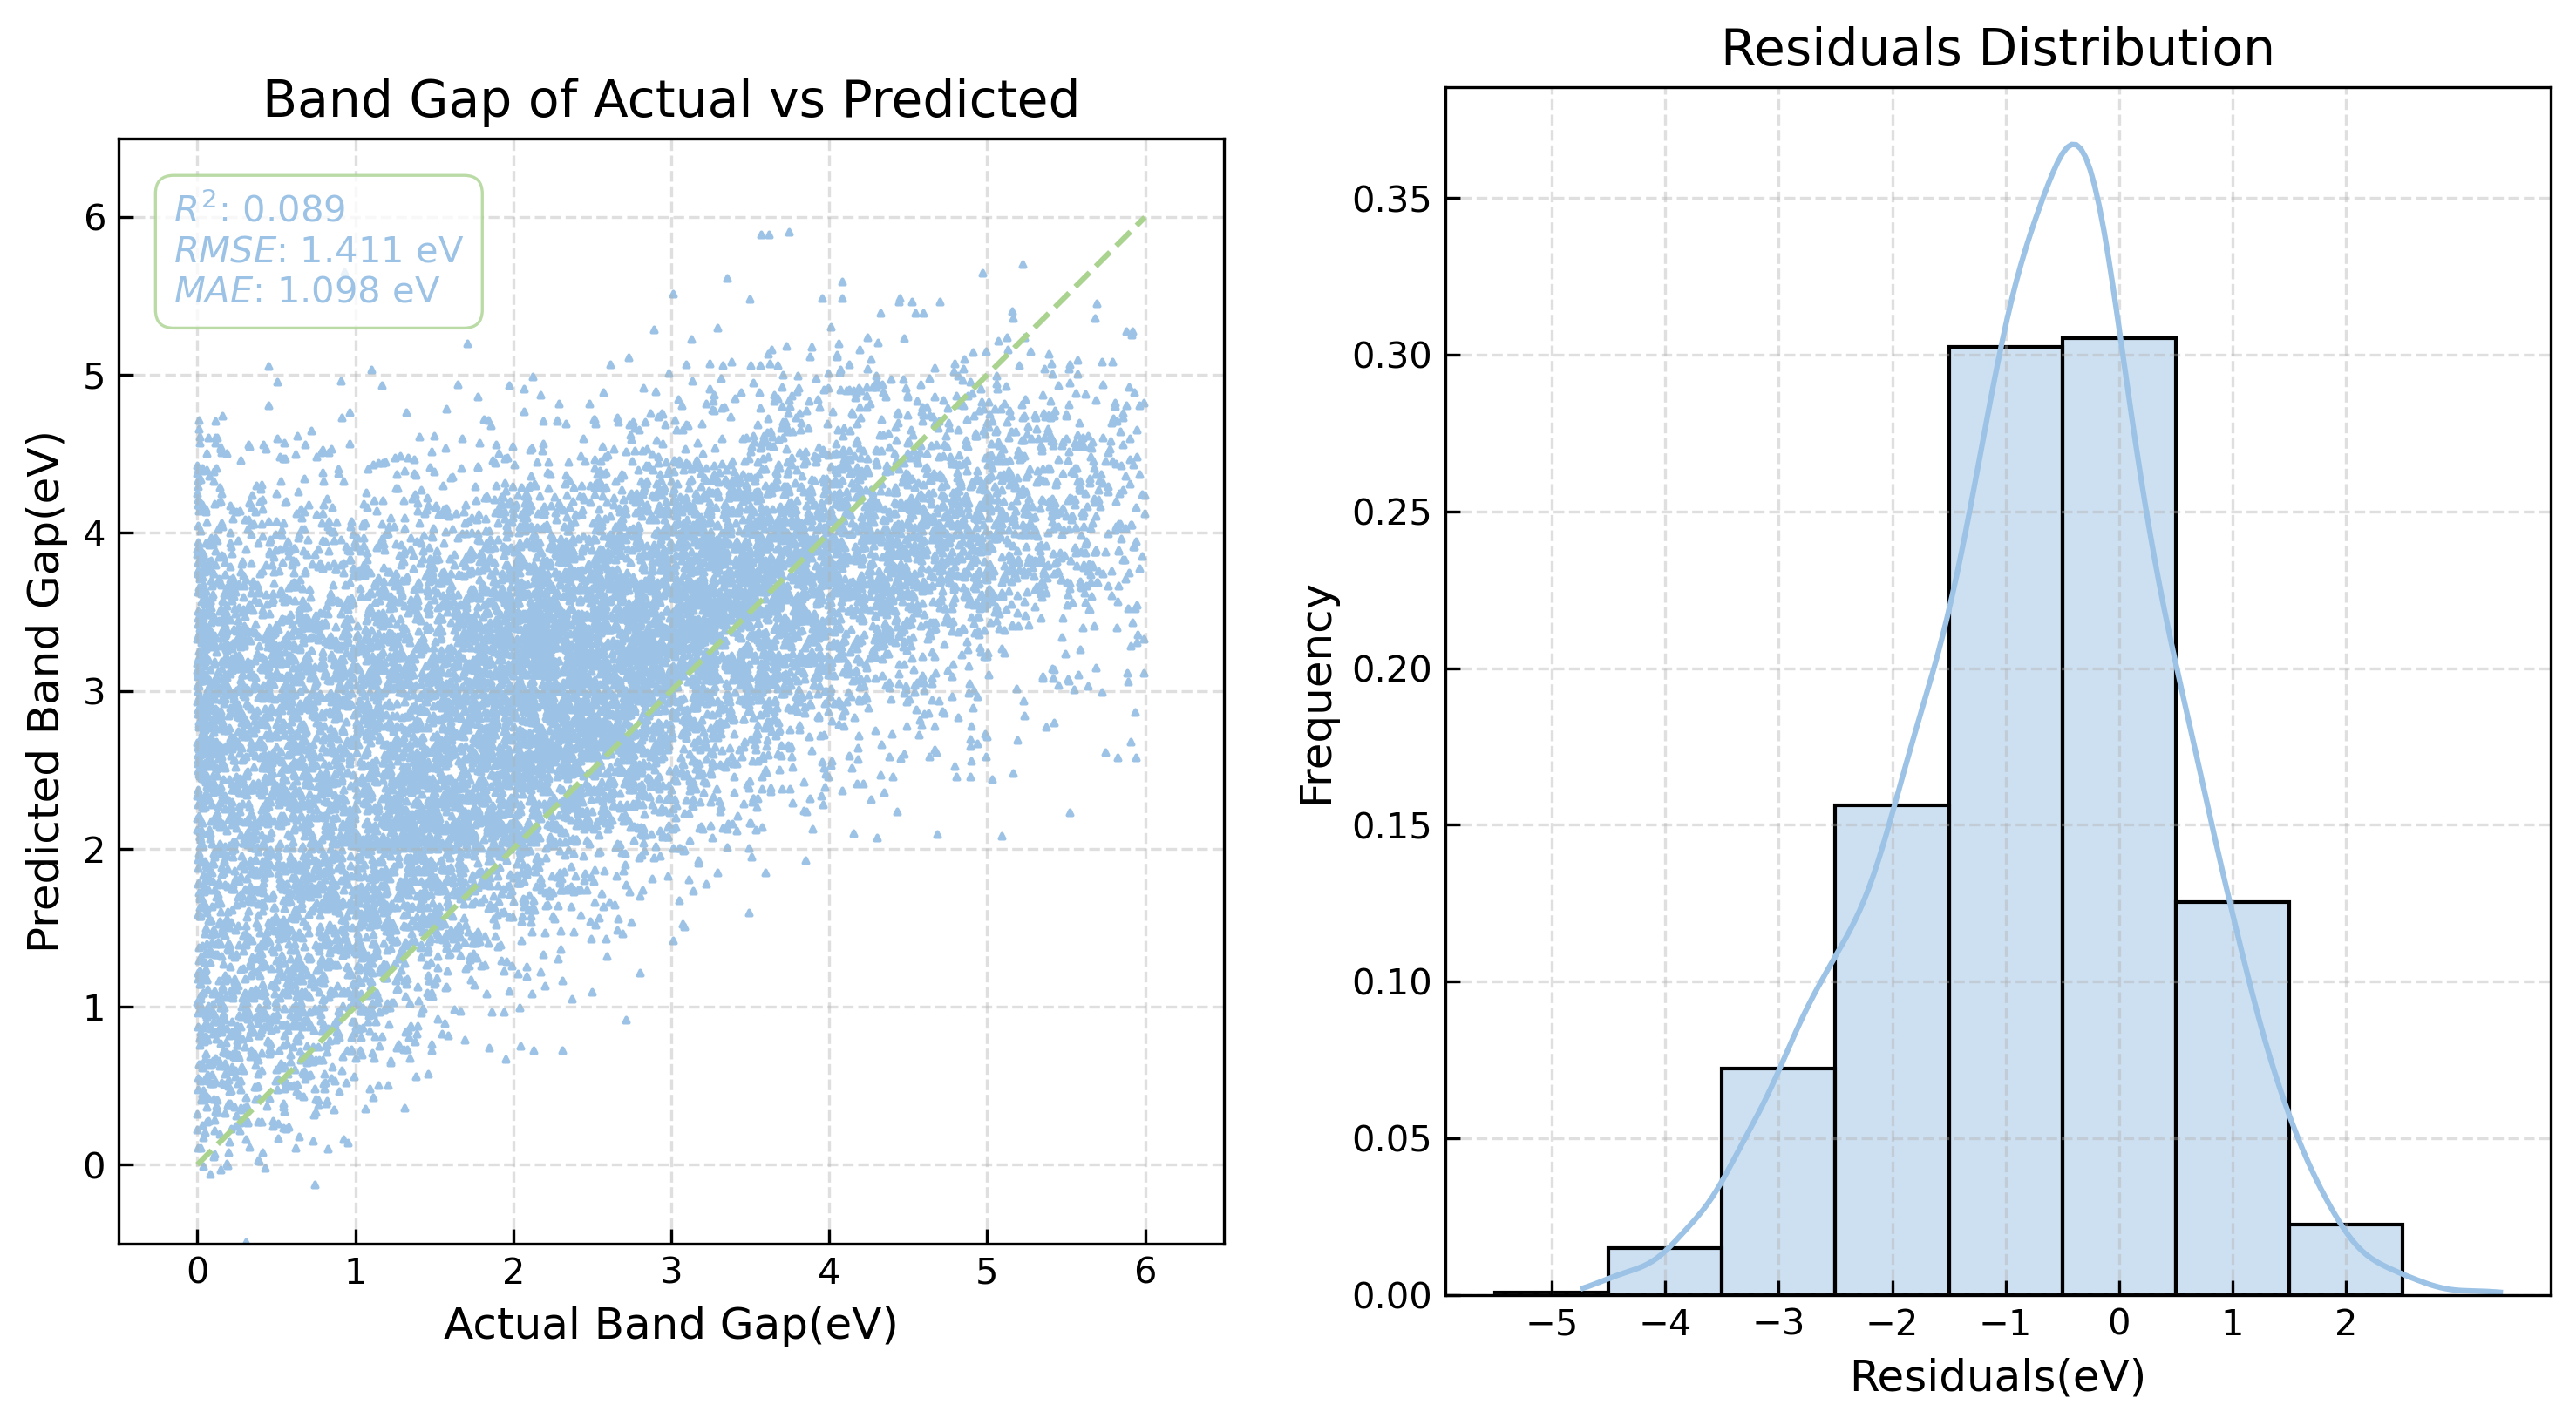


Model Evaluation Results:
Test set: R²: 0.0886 RMSE: 1.4111 MAE: 1.0981


In [53]:
# 
# Train the model with the best hyperparameters on the entire training set
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=500,
    colsample_bytree=1.0, subsample=1.0,
    objective='reg:squarederror',
    random_state=RANDOM_SEED,
    n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [54]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,exp,exp,0.989800,0.122544,0.089634
1,XGBoost,Test,exp,exp,0.810111,0.547615,0.383004
2,XGBoost,Test,exp,dft,0.088628,1.411108,1.098119
